In [1]:
# Research Kernel Link - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/4%20-%20ResNet50%20-%20Batch%20size%2022.ipynb

import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


8  CPU cores


In [3]:
import os
os.chdir('aptos2019')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  C:\Users\OM\model\aptos2019


In [4]:
os.getcwd()

'C:\\Users\\OM\\model\\aptos2019'

In [5]:
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_test', 'rb')
    df_train_test = pickle.load(file)
    file.close()
    
    return df_train_train,df_train_test

In [6]:
os.chdir('..')

In [7]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(2929, 4) (733, 4) 



,id_code,diagnosis,file_path,file_name
2735,bd9904495ccd,4,./train_images/bd9904495ccd.png,bd9904495ccd.png
1063,4c17e85686f0,0,./train_images/4c17e85686f0.png,4c17e85686f0.png
1828,80ed04a84a16,0,./train_images/80ed04a84a16.png,80ed04a84a16.png
1046,4aa3d771c5e4,0,./train_images/4aa3d771c5e4.png,4aa3d771c5e4.png
1491,686ed1dbae20,2,./train_images/686ed1dbae20.png,686ed1dbae20.png
3376,ea588d1e5d96,2,./train_images/ea588d1e5d96.png,ea588d1e5d96.png


In [8]:
IMG_SIZE = 512

In [9]:
os.chdir('aptos2019')

In [10]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','train_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [11]:
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [12]:
# Use 2 cores (colab)
# ref - https://stackoverflow.com/questions/1006289/how-to-find-out-the-number-of-cpus-using-python

#multiprocess_image_processor(2, list(df_train_train.id_code.values))

In [13]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [14]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "./test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [15]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [18]:
os.chdir("..")

In [19]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, include_top=False,input_tensor=input_tensor)
    base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [20]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 80, 80, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 10, 10, 2048  0           ['conv5_block1_0_bn[0][0]',      
                                )                                 'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 10, 10, 2048  0           ['conv5_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 10, 10, 512)  1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 10, 10, 512)  2048       ['conv5_block2_1_conv[0][0]']    
 ization) 

In [21]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [23]:
os.chdir('aptos2019')

In [24]:
model.compile(optimizer=optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

history_warmup = model.fit(train_generator,
                           steps_per_epoch=STEP_SIZE_TRAIN,
                           validation_data=valid_generator,
                           validation_steps=STEP_SIZE_VALID,
                           epochs=WARMUP_EPOCHS,
                           verbose=1).history

Epoch 1/2
293/293 [==============================] - 730s 2s/step - loss: 1.9684 - accuracy: 0.4164 - val_loss: 1.3695 - val_accuracy: 0.4418
Epoch 2/2
293/293 [==============================] - 601s 2s/step - loss: 1.3322 - accuracy: 0.5047 - val_loss: 1.2711 - val_accuracy: 0.4435


In [25]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 80, 80, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

D:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv3_block1_1_conv (Conv2D)   (None, 40, 40, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block4_1_conv (Conv2D)   (None, 40, 40, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 20, 20, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_add (Add)         (None, 20, 20, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 20, 20, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 10, 10, 2048  1050624     ['conv5_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 10, 10, 2048  8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv5_block2_add (Add)         (None, 10, 10, 2048  0           ['conv5_block1_out[0][0]',       
                                )                                 'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [26]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/40


C:\Users\OM\AppData\Local\Temp\ipykernel_11828\1317685637.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_finetunning = model.fit_generator(generator=train_generator,


293/293 [==============================] - 1804s 6s/step - loss: 0.3186 - accuracy: 0.7142 - val_loss: 0.4542 - val_accuracy: 0.3236 - lr: 1.0000e-04
Epoch 2/40
293/293 [==============================] - 1841s 6s/step - loss: 0.2240 - accuracy: 0.7590 - val_loss: 0.3884 - val_accuracy: 0.5411 - lr: 1.0000e-04
Epoch 3/40
293/293 [==============================] - 1803s 6s/step - loss: 0.1961 - accuracy: 0.7803 - val_loss: 0.4146 - val_accuracy: 0.6147 - lr: 1.0000e-04
Epoch 4/40
293/293 [==============================] - 2028s 7s/step - loss: 0.1896 - accuracy: 0.7935 - val_loss: 0.2313 - val_accuracy: 0.7517 - lr: 1.0000e-04
Epoch 5/40
293/293 [==============================] - 1980s 7s/step - loss: 0.1752 - accuracy: 0.8020 - val_loss: 0.2637 - val_accuracy: 0.6764 - lr: 1.0000e-04
Epoch 6/40
293/293 [==============================] - 1650s 6s/step - loss: 0.1660 - accuracy: 0.8247 - val_loss: 0.1891 - val_accuracy: 0.7825 - lr: 1.0000e-04
Epoch 7/40
293/293 [=========================

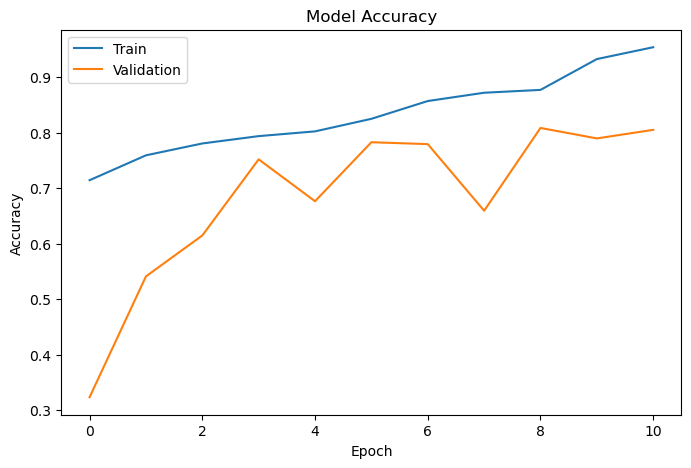

In [27]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

### <font color='red'> 9.4 Generate Train Predictions on complete Train Data </font>

In [28]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.


C:\Users\OM\AppData\Local\Temp\ipykernel_11828\1199064684.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)


2929/2929 [==============================] - 803s 273ms/step


In [29]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.865
Train Accuracy score : 0.855


### <font color='red'> 9.5 Evaluate Model on Test Data </font>

In [30]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

C:\Users\OM\AppData\Local\Temp\ipykernel_11828\2753895509.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)


733/733 [==============================] - 207s 282ms/step


In [31]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

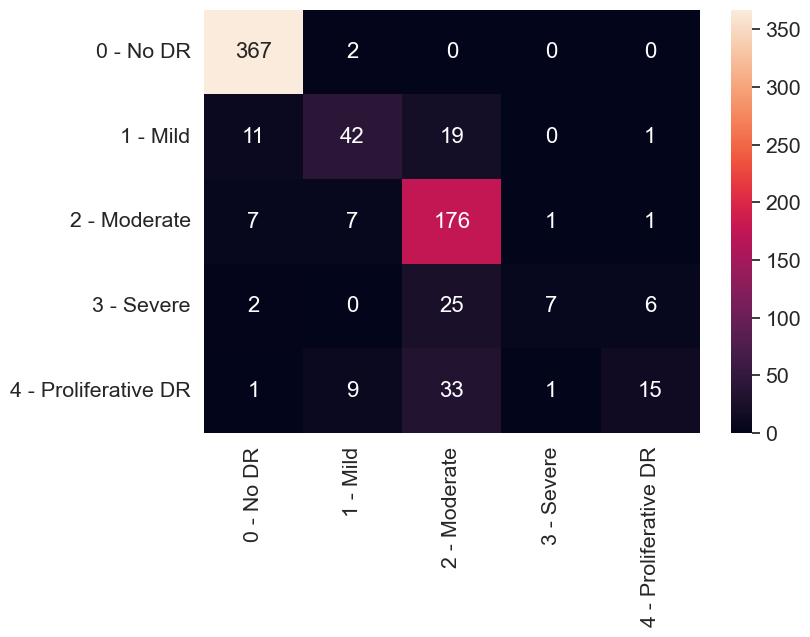

In [32]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

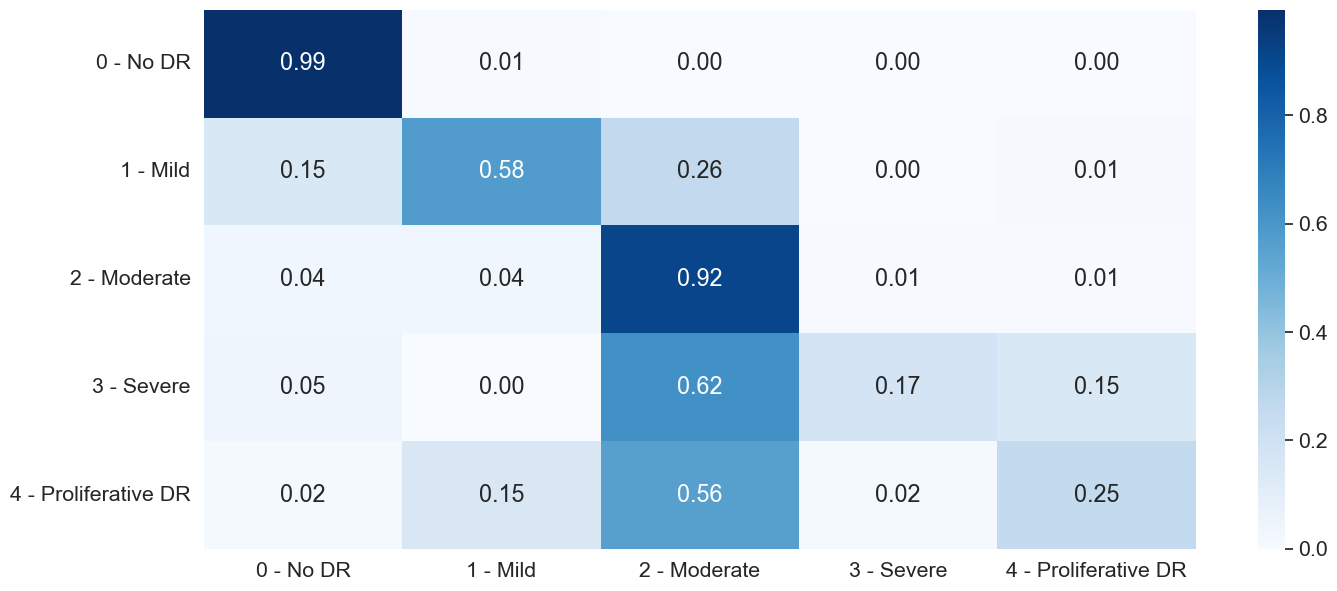

In [33]:
cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [34]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.832
Test Accuracy score : 0.828


### <font color='red'> 9.6 ResNet50 Models Summary </font>

In [35]:
x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+


In [36]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(create_model, f)

In [37]:
model.save("model.h5")